# Overview
The purpose of this tutorial is to provide a user-friendly way to deliver and ingest Planetary variables into Sentinel Hub in a Bring Your Own Cog collection. 
This sample handles a soil water content (SWC) subscription. 

We will go through 
- creating a BYOC collection
- ingesting tiles into that collection
- running some stats on the data
- visualzing the data

## Setup
You will need 
- A sentinel hub account
- An AWS s3 bucket in `eu-central-1` or `us-west-2`
  - Configure the s3 bucket so sentinel hub can read from it with these [permissions](https://docs.sentinel-hub.com/api/latest/api/byoc/#bucket-settings)
- A Planetary variable SWC subscription, delivered to s3 
- An oauth sentinel hub client created 
- a [sentinel hub config file](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#configuration-file) that contains the following: (fill in your sentinel hub and AWS information)
 ```
     [default-profile]
     sh_client_id = ""
     sh_client_secret = ""
     sh_base_url = "https://services.sentinel-hub.com"
     sh_token_url="https://services.sentinel-hub.com/oauth/token"
     aws_access_key_id = ""
     aws_secret_access_key = ""
 ```
 - Python dependencies 
 `pip install -q boto3 matplotlib pandas geopandas seaborn sentinelhub`


## Create a new collection

In [1]:
# set up variables
collection_name = "My SWC Collection"
bucket_name = "name-of-your-s3-bucket"
geometry = {
        "coordinates": [
            [
                [-113.09111599999999,38.24378800000002],
                [-113.062253,38.38971299999997],
                [-112.969161,38.39210800000001],
                [-112.94513799999999,38.257329],
                [-113.09111599999999,38.24378800000002]
            ]
        ],
        "type": "Polygon"
      }
## the source id: 
## from https://developers.planet.com/earlyaccess/rel-pv-eap/docs/subscriptions/pvs-subs/#planetary-variables-types-and-ids
product_name = "SWC-AMSR2-X_V4.0_1000"

# the time you want to ingest data from (should match your subscription request)
time_interval = ("2020-01-01", "2020-12-31")
# picking a date in the spring, so we can see non frozen soil
date_to_visualize = "2020-05-03" 

In [2]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import json

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    Geometry,
    MimeType,
    SentinelHubBYOC,
    SentinelHubStatistical,
    SentinelHubRequest,
    SHConfig,
    parse_time,
    bbox_to_dimensions,
)

config = SHConfig()
byoc = SentinelHubBYOC(config=config)

In [3]:
band_config = ByocCollectionAdditionalData(
    bands={
        "swc": ByocCollectionBand(source="swc", band_index=1, bit_depth=16, sample_format="UINT", no_data=65535),
        "usability": ByocCollectionBand(source="swc", band_index=2, bit_depth=16, sample_format="UINT", no_data=65535),
        "qf": ByocCollectionBand(source="swc-qf", band_index=1, bit_depth=16, sample_format="UINT"),
    }
)

swc_collection = ByocCollection(
    name=collection_name, 
    s3_bucket=bucket_name, 
    additional_data=band_config
    )
 
created_collection = byoc.create_collection(swc_collection)
print("name:", created_collection["name"])
print("bands:", created_collection["additionalData"])



name: My SWC Collection
bands: {'bands': {'swc': {'bitDepth': 16, 'source': 'swc', 'bandIndex': 1, 'noData': 65535, 'sampleFormat': 'UINT'}, 'usability': {'bitDepth': 16, 'source': 'swc', 'bandIndex': 2, 'noData': 65535, 'sampleFormat': 'UINT'}, 'qf': {'bitDepth': 16, 'source': 'swc-qf', 'bandIndex': 1, 'sampleFormat': 'UINT'}}}


## Add tiles to collection.

In [4]:
def list_objects_path(bucket, year_count, month_count, day_count, config):
    tiles_path = []
    client = boto3.client(
        "s3", aws_access_key_id=config.aws_access_key_id, aws_secret_access_key=config.aws_secret_access_key
    )
    result = client.list_objects(Bucket=bucket, Delimiter="/")
    for year in result.get("CommonPrefixes")[:year_count]:
        year_result = client.list_objects(Bucket=bucket, Delimiter="/", Prefix=year.get("Prefix"))
        for month in year_result.get("CommonPrefixes")[:month_count]:
            month_result = client.list_objects(Bucket=bucket, Delimiter="/", Prefix=month.get("Prefix"))
            for day in month_result.get("CommonPrefixes")[:day_count]:
                day_result = client.list_objects(Bucket=bucket, Delimiter="/", Prefix=day.get("Prefix"))
                for tile in day_result.get("CommonPrefixes"):
                    tiles_path.append(tile.get("Prefix"))
    return tiles_path



In [5]:
tiles_path = list_objects_path(
    bucket=bucket_name, year_count=1, month_count=1, day_count=30, config=config
)

In [6]:
for tile in tiles_path:
    sub_id, year, month, day = tile.split("/")[:4]
    datetimestr = f"{year}{month}{day}T0130"
    datetime = dt.datetime(int(year), int(month), int(day))
    filename = f"{product_name}-{datetimestr}_(BAND).tiff"
    filepath = f"{tile}{filename}"
    print("filepath", filepath)
    byoc_tile = ByocTile(path=filepath, sensing_time=datetime)
    byoc.create_tile(created_collection, byoc_tile)

filepath 229f7e24-db4e-4382-85a0-71ebdc947e13/2020/04/07/SWC-AMSR2-X_V4.0_1000-20200407T0130_(BAND).tiff
filepath 229f7e24-db4e-4382-85a0-71ebdc947e13/2020/04/08/SWC-AMSR2-X_V4.0_1000-20200408T0130_(BAND).tiff
................................truncated this will print a year of data................................


## Check tile ingest

In [7]:
tiles = list(byoc.iter_tiles(created_collection))
# let's see a tile, and see how many were ingested
print(json.dumps(tiles[0], indent=2))
tile_length = len(tiles)

{
  "id": "01bf5403-fb81-4a8b-ae1b-cfb6b99c2982",
  "created": "2023-05-19T17:24:03.568877Z",
  "ingestionStart": "2023-05-19T17:24:03.568877Z",
  "sensingTime": "2020-11-28T00:00:00Z",
  "coverGeometry": {
    "type": "Polygon",
    "crs": {
      "type": "name",
      "properties": {
        "name": "urn:ogc:def:crs:OGC::CRS84"
      }
    },
    "coordinates": [
      [
        [
          -113.09909909911153,
          38.24324324324745
        ],
        [
          -112.93693693694935,
          38.24324324324745
        ],
        [
          -112.93693693694935,
          38.39639639640062
        ],
        [
          -113.09909909911153,
          38.39639639640062
        ],
        [
          -113.09909909911153,
          38.24324324324745
        ]
      ]
    ]
  },
  "tileGeometry": {
    "type": "Polygon",
    "crs": {
      "type": "name",
      "properties": {
        "name": "urn:ogc:def:crs:OGC::CRS84"
      }
    },
    "coordinates": [
      [
        [
       

In [8]:
# check if any tiles failed to ingest
tiles_failed_to_be_ingested = [tile["path"] for tile in tiles if tile["status"] == "FAILED"]
print("failed ingests", tiles_failed_to_be_ingested)

failed ingests []


## Set up visuals 

In [9]:
tile_iterator = byoc.iter_tiles(created_collection)

In [10]:
tiles_for_visualized = []
for i in range(tile_length):
    tiles_for_visualized.append(ByocTile.from_dict(next(tile_iterator)))

tiles_gdf = gpd.GeoDataFrame(
    tiles_for_visualized,
    geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles_for_visualized],
    crs="epsg:4326",
)


In [11]:
tiles_gdf.head()


,path,status,tile_id,tile_geometry,cover_geometry,created,sensing_time,ingestion_start,additional_data,other_data,geometry
0,08a5b431-ace2-4d26-8bb2-120bf5ce3dde/2020/11/2...,INGESTED,01bf5403-fb81-4a8b-ae1b-cfb6b99c2982,Geometry(POLYGON ((-113.09909909911153 38.3963...,Geometry(POLYGON ((-113.09909909911153 38.2432...,2023-05-19 17:24:03.568877+00:00,2020-11-28 00:00:00+00:00,2023-05-19 17:24:03.568877+00:00,"{'filesMetadata': {'swc': {'headerSize': 726, ...",{},"POLYGON ((-113.09910 38.24324, -112.93694 38.2..."
1,08a5b431-ace2-4d26-8bb2-120bf5ce3dde/2020/09/1...,INGESTED,0434754d-f0a2-4aaf-be81-edd608b7a4f1,Geometry(POLYGON ((-113.09909909911153 38.3963...,Geometry(POLYGON ((-113.09909909911153 38.2432...,2023-05-19 17:23:16.163131+00:00,2020-09-16 00:00:00+00:00,2023-05-19 17:23:16.163131+00:00,"{'filesMetadata': {'swc': {'headerSize': 726, ...",{},"POLYGON ((-113.09910 38.24324, -112.93694 38.2..."
2,08a5b431-ace2-4d26-8bb2-120bf5ce3dde/2020/11/2...,INGESTED,044b9e65-2b54-4bff-985c-99defd6fa6a8,Geometry(POLYGON ((-113.09909909911153 38.3963...,Geometry(POLYGON ((-113.09909909911153 38.2432...,2023-05-19 17:24:00.358246+00:00,2020-11-23 00:00:00+00:00,2023-05-19 17:24:00.358246+00:00,"{'filesMetadata': {'swc': {'headerSize': 726, ...",{},"POLYGON ((-113.09910 38.24324, -112.93694 38.2..."
3,08a5b431-ace2-4d26-8bb2-120bf5ce3dde/2020/12/2...,INGESTED,0596ae16-c47f-480e-9899-846d3d094a98,Geometry(POLYGON ((-113.09909909911153 38.3963...,Geometry(POLYGON ((-113.09909909911153 38.2432...,2023-05-19 17:24:20.179223+00:00,2020-12-23 00:00:00+00:00,2023-05-19 17:24:20.179223+00:00,"{'filesMetadata': {'swc': {'headerSize': 726, ...",{},"POLYGON ((-113.09910 38.24324, -112.93694 38.2..."
4,08a5b431-ace2-4d26-8bb2-120bf5ce3dde/2020/06/2...,INGESTED,065563bc-641e-4ba9-b59e-7ffbee432d86,Geometry(POLYGON ((-113.09909909911153 38.3963...,Geometry(POLYGON ((-113.09909909911153 38.2432...,2023-05-19 17:22:22.024135+00:00,2020-06-25 00:00:00+00:00,2023-05-19 17:22:22.024135+00:00,"{'filesMetadata': {'swc': {'headerSize': 726, ...",{},"POLYGON ((-113.09910 38.24324, -112.93694 38.2..."


In [12]:
geom = Geometry.from_geojson(geometry)

swc_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
    {
      bands: ["swc"],
    }
    ],
    output: [
      {
        id: "Gray",
        bands: 1,
        sampleType: "FLOAT32"
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(samples) {
    let dm = samples.swc == 65535 ? 0 : 1;
    return {
      Gray: [samples.swc],
      dataMask: [dm]
    };
}
"""

## Statistical API Requests

We get summary statistics + histogram

In [13]:
collection_id = created_collection["id"]

calculations = {"default": {"statistics": {"default": {"percentiles": {"k": [50]}}}, "histograms": {"default": {"nBins": 20}}}}


byocDC = DataCollection.define_byoc(collection_id=collection_id)

swc_stats = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=swc_evalscript,
        time_interval=time_interval,
        aggregation_interval="P1D",
    ),
    input_data=[SentinelHubStatistical.input_data(byocDC)],
    calculations=calculations,
    geometry=geom,
    config=config,
)

swc_stats_dl = swc_stats.get_data()



In [14]:
# from https://sentinelhub-py.readthedocs.io/en/latest/examples/statistical_request.html
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break
                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

### Some Lint plots of summary stats


In [15]:
swc_df = stats_to_df(swc_stats_dl[0])
swc_df.head()

,interval_from,interval_to,Gray_B0_min,Gray_B0_max,Gray_B0_mean,Gray_B0_stDev,Gray_B0_sampleCount,Gray_B0_noDataCount,Gray_B0_percentiles_50.0
0,2020-04-07,2020-04-08,0.0,144.0,99.305984,53.025725,65536,0,124.0
1,2020-04-08,2020-04-09,0.0,309.0,229.444305,121.763633,65536,0,291.0
2,2020-04-09,2020-04-10,0.0,0.0,0.000000,0.000000,65536,51186,0.0
3,2020-04-10,2020-04-11,0.0,219.0,160.751694,85.466108,65536,0,203.0
4,2020-04-11,2020-04-12,0.0,0.0,0.000000,0.000000,65536,51186,0.0


In [16]:
swc_df.tail()

,interval_from,interval_to,Gray_B0_min,Gray_B0_max,Gray_B0_mean,Gray_B0_stDev,Gray_B0_sampleCount,Gray_B0_noDataCount,Gray_B0_percentiles_50.0
263,2020-12-26,2020-12-27,0.0,246.0,182.072403,96.643695,65536,0,230.0
264,2020-12-27,2020-12-28,0.0,250.0,185.808609,98.587068,65536,0,236.0
265,2020-12-28,2020-12-29,0.0,260.0,192.449997,102.181499,65536,0,243.0
266,2020-12-29,2020-12-30,0.0,229.0,171.150192,90.779769,65536,0,217.0
267,2020-12-30,2020-12-31,0.0,0.0,0.000000,0.000000,65536,51186,0.0


## Visualize with the process api

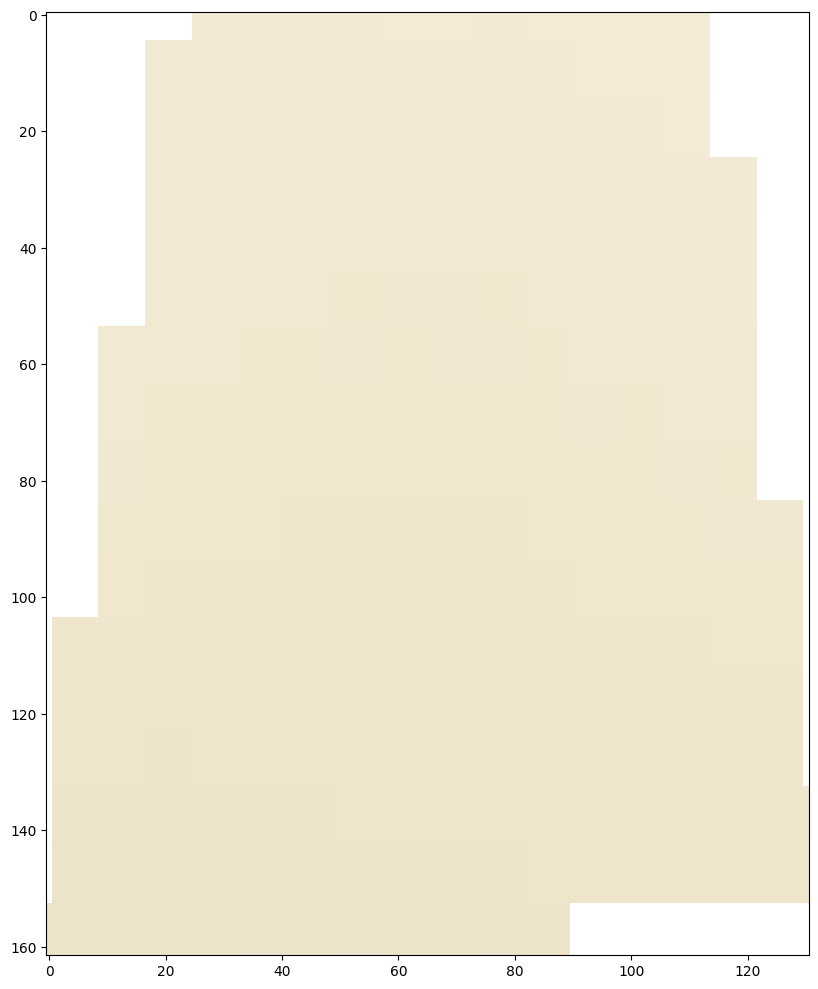

In [17]:
swc_processing_evalscript = """
//VERSION=3

//Set up input and output settings
function setup() {
  return {
    input: ["swc"],
    output: {
      bands: 4,
      sampleType: "AUTO"
    }
  }
}

//Create color ramp
const swc_ramp = [
    [0, 0xfffaed],
    [100, 0xeee5cb],
    [200, 0xced3ad],
    [300, 0xa8c394],
    [400, 0x7bb383],
    [500, 0x3ea37d],
    [600, 0x00937e],
    [700, 0x008284],
    [800, 0x006f8b],
    [900, 0x005a94],
    [1000, 0x003ea0],
];

//Create visualizer
const visualizer = new ColorRampVisualizer(swc_ramp);

//EvaluatePixel function
function evaluatePixel(sample) {
  if (sample.swc == 65535){  //Not water
    return [1, 1, 1, 0]            //Return 
  }else{ //1 - 100% occurrence
    return [visualizer.process(sample.swc)[0], visualizer.process(sample.swc)[1], visualizer.process(sample.swc)[2], 1];  //Return color ramp values
  }
}
"""


request = SentinelHubRequest(
    evalscript=swc_processing_evalscript,
    input_data=[SentinelHubRequest.input_data(data_collection=byocDC, time_interval=date_to_visualize)],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=geom.bbox,
    size=bbox_to_dimensions(geom.bbox, 100),
    config=config,
)

data = request.get_data()[0]

fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(data)
plt.tight_layout()
